# Cats vs Dogs  Solve
https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

Using VGG16 model to solve above kaggle competition

Usage Notes:
* Cells should be convereted to raw if they don't need to be run

Things to work on:
* Loop over training and learning rate array
* Data augmentation
* Save VGG16 architecture to file and just load that shit!

References
* https://github.com/fastai/courses/blob/master/deeplearning1/nbs/dogscats-ensemble.ipynb
* https://github.com/fastai/courses/blob/master/deeplearning1/nbs/dogs_cats_redux.ipynb


Process
1. Start as VGG16 model
1. Train the last layer, precomputing the rest

## Initialisation

In [1]:
import numpy as np
import pandas as pd
import os.path

from vgg16 import VGG_16
from utils import *

#Jupyter Specific
%matplotlib inline
from IPython.display import display

Using Theano backend.


In [2]:
# Parameters
dir_case = './data/dogscats/'
dir_data = dir_case + 'sample/'
ensambles_nb = 3

# Sane Defaults, but feel free to change
dir_model =  dir_case + 'model/'
dir_submissions =  dir_case + 'submissions/'
fname_submission =  'Kaggle_CatsDogs'
fname_stats = dir_case + 'stats.csv'
batch_size = 24

In [3]:
def pred_ensamble(models, generator):
    pred_test = 0
    
    for model in models:
        pred_test += model.predict_gen(generator)
        
    pred_test /= len(models)
    
    return pred_test

In [4]:
generators = {}

generators['train'] = image.ImageDataGenerator().flow_from_directory(dir_data+'train', 
                                                                     batch_size=batch_size,
                                                                     shuffle=True,
                                                                     class_mode='categorical',
                                                                     target_size=VGG_16.IMAGE_SIZE)

generators['valid'] = image.ImageDataGenerator().flow_from_directory(dir_data+'valid', 
                                                                     batch_size=batch_size,
                                                                     shuffle=False,
                                                                     class_mode='categorical',
                                                                     target_size=VGG_16.IMAGE_SIZE)

generators['test']  = image.ImageDataGenerator().flow_from_directory(dir_data+'test', 
                                                                     batch_size=batch_size,
                                                                     shuffle=False,
                                                                     class_mode=None,
                                                                     target_size=VGG_16.IMAGE_SIZE)

Found 145 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 13 images belonging to 1 classes.


In [5]:
VGG16 = VGG_16(generators, batch_size=24)

In [5]:
model.summary()

NameError: name 'model' is not defined

In [22]:
def model_splitter(model, layer_type):
    layers = model.layers
    #layer_idx = [index for index,layer in enumerate(layers)
    #             if type(layer) is layer_type][-1]
    layer_idx = 33
    
    model_1 = Sequential()
    for l in layers[:layer_idx]:
        model_1.add(l)
    
    model_2 = Sequential()
    model_1_output_shape = model_1.layers[-1].output_shape
    model_1_output_shape = model_1_output_shape[1]
    model_2.add(InputLayer(input_shape=(25088,)))
    for l in layers[layer_idx:]:
        model_2.add(l)
        
    return (model_1, model_2)

model = VGG16.model
(conv_model, dense_model) = model_splitter(model, 'flatten')

In [23]:
dense_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 25088)         0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 4096)          0           flatten_1[0][0]                  
                                                                   input_9[0][0]                    
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 4096)          0           dense_1[0][0]                    
                                                                   dense_1[1][0]                    
___________________________________________________________________________________________

In [16]:

os = conv_model.layers[-1].output_shape
os[1]

25088

In [29]:
lay = dense_model.layers[0]
display(print_layer_summary_with_connections(lay))
        

NameError: name 'print_layer_summary_with_connections' is not defined

In [29]:
dense_model.layers[0].get_config()
dense_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_8 (Dense)                  (None, 4096)          0           flatten_2[0][0]                  
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 4096)          0           dense_8[0][0]                    
                                                                   dense_8[0][0]                    
                                                                   dense_8[0][0]                    
____________________________________________________________________________________________________
dense_9 (Dense)                  (None, 4096)          0           dropout_3[0][0]                  
                                                                   dropout_3[1][0]         

In [21]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_2 (Lambda)                (None, 3, 224, 224)   0           lambda_input_2[0][0]             
____________________________________________________________________________________________________
zeropadding2d_14 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_2[0][0]                   
                                                                   lambda_2[0][0]                   
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_14[0][0]           
                                                                   zeropadding2d_14[1][0]           
___________________________________________________________________________________________

In [69]:
ind = model.get_layer(name="Flatten")
display(ind)

None

In [11]:
conv_model.layers[-1].output_shape

(None, 25088)

In [25]:
pred_conv = conv_model.predict_generator(generators['valid'], generators['valid'].nb_sample)

In [8]:
display(pred_conv.shape)
pred_conv[:5]

(8, 25088)

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

In [16]:
dmod.compile(optimizer=Adam(lr=-1.0001),
                           loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
conv_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  0           zeropadding2d_1[1][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[1][0]            
___________________________________________________________________________________________

In [8]:
display(dense_model.summary())

dmod = Sequential()
dmod.add(Dense(4096, activation='relu', input_shape=(25088,)))
dmod.add(Dense(4096, activation='relu'))
dmod.add(Dense(2, activation='softmax'))
dmod.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  multiple              0                                            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 4096)          0           dense_1[0][0]                    
                                                                   dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 4096)          0           dropout_1[0][0]                  
                                                                   dropout_1[1][0]                  
___________________________________________________________________________________________

None

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_5 (Dense)                  (None, 4096)          102764544   dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 4096)          16781312    dense_5[0][0]                    
____________________________________________________________________________________________________
dense_7 (Dense)                  (None, 2)             8194        dense_6[0][0]                    
Total params: 119554050
____________________________________________________________________________________________________


In [17]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 3, 224, 224)   0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
zeropadding2d_27 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_3[0][0]                   
____________________________________________________________________________________________________
convolution2d_27 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_27[0][0]           
____________________________________________________________________________________________________
zeropadding2d_28 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_27[0][0]           
___________________________________________________________________________________________

In [26]:
dense_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

dense_model.fit(pred_conv, generators['train'].classes, batch_size=batch_size, validation_data=None, shuffle=False)


Exception: Error when checking model target: expected dense_4 to have shape (None, 2) but got array with shape (145, 1)

## Tracking State

We track data about the training process in a Pandas dataframe

In [4]:
### Load stats if found, otherwise create a blank one
if os.path.exists(fname_stats):
    stats = pd.read_csv(fname_stats)
else:
    stats = pd.DataFrame(columns=['model','epoch','learning_rate','acc','loss','val_acc','val_loss'])

    
display(stats.head())
    

,model,epoch,learning_rate,acc,loss,val_acc,val_loss


In [7]:
latests_models = []
for m in range(0, ensambles_nb):
    ind = stats.query('model==@m')['epochs'].idxmax()
    latests_models.append(ind)

stats_sum = stats.iloc[latests_models]
display(stats_sum.head())
    

ValueError: attempt to get argmax of an empty sequence

## Loading the Data

## Model Creation

In [6]:
models = []
for m in range(0, ensambles_nb):
    models.append(VGG_16(generators, batch_size=24))
    fname_model =  '{}weights_model{:02d}.h5'.format(dir_model, m)
    if os.path.exists(fname_model):
        models[m].model.load_weights(fname_model)
        print( 'Loaded Weights from: {}'.format(fname_model) )
    else:
        print('Created new weights: {}'.format(fname_model))
    

Loaded Weights from: ./data/dogscats/model/weights_model00.h5
Loaded Weights from: ./data/dogscats/model/weights_model01.h5
Loaded Weights from: ./data/dogscats/model/weights_model02.h5


In [10]:
training = np.array([
#    [0.030, 2],
#    [0.010, 2],
    [0.001, 1],
])
m=0
for model in models:
    print('Training model {:02d}'.format(m))
    for step in training:
        model.lr = step[0]
        for epoch in range(0,int(step[1])):
            
            epochs_current = stats.query('model==@m')['epoch'].max() + 1
            
            # if we didn't find anything in the dataframe, it must be a new model
            if np.isnan(epochs_current):
                epochs_current = 0
            
            print('Training epoch {} at {}'.format(epochs_current, model.lr))

            # Train single epoch
            hist = model.fit_gen(nb_epoch=1)
            
            # Update stats
            stats_slug = {}
            
            # Convert results array to float
            for key in hist.history:
                hist.history[key] = float(hist.history[key][0])

            # Add learning parameters
            stats_slug.update({'model': m,
                              'epoch': epochs_current,
                              'learning_rate': model.lr})
            
            ## Add accuracy
            stats_slug.update(hist.history)

            stats = stats.append(stats_slug, ignore_index=True)
            
            #['model','epochs','learning_rate','loss', 'acc','loss_val','acc_val']
            
            model.model.save_weights(fname_model)
            
    # Go to next model
    m += 1

Training model 00
Training epoch 1.0 at 0.001
Epoch 1/1
145/145 [==============================] - 34s - loss: 0.1117 - acc: 0.9931 - val_loss: 2.0148 - val_acc: 0.8750
Training model 01
Training epoch 1.0 at 0.001
Epoch 1/1
145/145 [==============================] - 36s - loss: 0.0848 - acc: 0.9724 - val_loss: 2.0039 - val_acc: 0.8750
Training model 02
Training epoch 1.0 at 0.001
Epoch 1/1
145/145 [==============================] - 35s - loss: 3.4566e-06 - acc: 1.0000 - val_loss: 2.0150 - val_acc: 0.8750


In [11]:
stats.to_csv(fname_stats, index=False)
display(stats.head(10))

,model,epoch,learning_rate,acc,loss,val_acc,val_loss
0,0.0,0.0,0.001,0.958621,0.197055,0.875,1.681687
1,1.0,0.0,0.001,0.958621,0.303674,0.875,0.815625
2,2.0,0.0,0.001,0.993103,0.015648,0.875,2.014769
3,0.0,1.0,0.001,0.993103,0.111720,0.875,2.014762
4,1.0,1.0,0.001,0.972414,0.084774,0.875,2.003941
5,2.0,1.0,0.001,1.000000,0.000003,0.875,2.014981


## Precomputing up to the last layer

In [7]:

model.model.pop()
model.compile()

In [10]:
preds = model.predict_gen(model.gen_valid)
display(preds[:5])

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  1.2358, ...,  0.3207,  0.    ,  0.6208],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  1.7824],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  3.24  ,  0.    ],
       [ 0.    ,  0.    ,  3.3052, ...,  0.    ,  0.    ,  0.    ]], dtype=float32)

(imgs, labels) = next(model.gen_train)

n = 4
imgs = imgs[:4]
labels = labels[:4]
plots(imgs, titles=labels) #Use utily.py plot function for ease


print(model.predict(imgs))


## Explore Trained model

In [16]:
classes = model.classes
classes

['cats', 'dogs']

In [12]:
# Get predictions for validation set
preds_valid = pred_ensamble(models, generators[1])
fnames_valid = np.array(generators[1].filenames)
#strip category folder
#fnames = np.array([f[f.find('/')+1:] for f in fnames])

display(preds_valid[:10])
display(fnames_valid[:10])

array([[  1.0000e+00,   2.8735e-39],
       [  1.0000e+00,   3.9324e-30],
       [  1.0000e+00,   1.8369e-34],
       [  1.0000e+00,   8.9141e-12],
       [  1.6412e-26,   1.0000e+00],
       [  9.0092e-20,   1.0000e+00],
       [  5.8430e-04,   9.9942e-01],
       [  1.0000e+00,   5.0396e-08]], dtype=float32)

array(['cats/cat.10435.jpg', 'cats/cat.4319.jpg', 'cats/cat.4785.jpg', 'cats/cat.5202.jpg',
       'dogs/dog.10459.jpg', 'dogs/dog.11314.jpg', 'dogs/dog.4090.jpg', 'dogs/dog.5697.jpg'],
      dtype='|S18')

In [13]:
# Convert predictions into a label
labels_pred = np.round(preds_valid[:,1]) #Get probality it is dog

labels_pred[:10]

array([ 0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.], dtype=float32)

(2000, 2)

In [14]:
# get labels
labels_actual = generators[1].classes
labels_actual[:10]


array([0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

[[ 1.    0.  ]
 [ 0.25  0.75]]


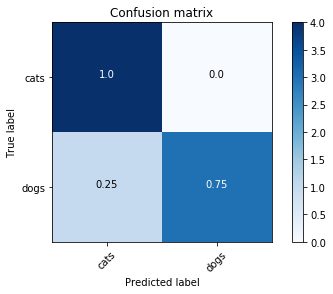

In [17]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_actual, labels_pred)

plot_confusion_matrix(cm, classes, normalize=True)

In [18]:
from keras.preprocessing import image

valid_path = dir_data + 'valid/'
#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + fnames_valid[i]) for i in idx], titles=titles)

n_view = 6

Found 7 correct labels


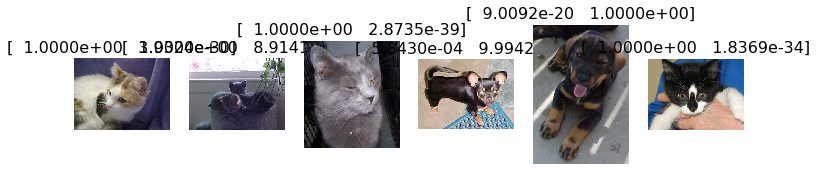

In [19]:
#1. A few correct predictions at random
correct = np.where(labels_actual==labels_pred)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, preds_valid[idx])

Found 1 correct labels


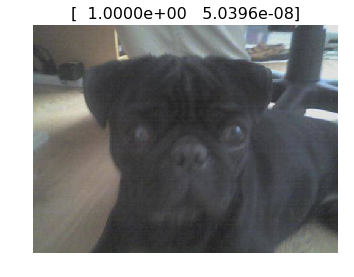

In [20]:
#1. A few incorrect predictions at random
correct = np.where(labels_actual!=labels_pred)[0]
print "Found %d correct labels" % len(correct)
idx = permutation(correct)[:n_view]
plots_idx(idx, preds_valid[idx])

In [22]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((labels_pred==0) & (labels_pred==labels_actual))[0]
print "Found %d confident correct cats labels" % len(correct_cats)
most_correct_cats = np.argsort(preds_valid[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], preds_valid[correct_cats][most_correct_cats])

Found 4 confident correct cats labels


TypeError: ufunc 'add' did not contain a loop with signature matching types dtype('S29') dtype('S29') dtype('S29')

In [15]:
len(models)

3

## Output Submission

Format Kaggle requires for submissions:
```
    imageId,isDog
    1242, .3984
    3947, .1000
    4539, .9082
    2345, .0000
```

In [1]:
# Run model on test data and get predictions
pred_test = pred_ensamble(models, generators[2])


display(pred_test[:5])


NameError: name 'pred_ensamble' is not defined

In [42]:
classes = model.classes
display(classes)

['cats', 'dogs']

In [8]:
# Grab dog predictions
isDog = pred_test[:,1]

#Get imageids, then strip category folder and extension
imageId = np.array(model.gen_test.filenames)
imageId = np.array([f[f.find('/')+1:] for f in imageId]) #strip category folder
imageId = np.array([f[:f.find('.')] for f in imageId]) #strip filename

display(isDog[:5])
display(imageId[:5])

array([  2.9409e-34,   1.6811e-26,   3.4535e-29,   1.0109e-05,   1.0000e+00], dtype=float32)

array(['00001', '00002', '00003', '00004', '00005'],
      dtype='|S5')

### Kaggle Evaluation

Kaggle uses categorical log loss defined as:

$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]$$
- $n$ is the number of images in the test set
- $\hat{y}_i$  is the predicted probability of the image being a dog
- $y_i$ is 1 if the image is a dog, 0 if cat
- $log()$ is the natural (base e) logarithm

As shown in the plot below, there is a "infinte" penality for predicting the wrong label with high confidence, i.e. predicting 0 when it should be 1. A trick to improve kaggle score is to clip the confident predictions.

The clipping amount is random 

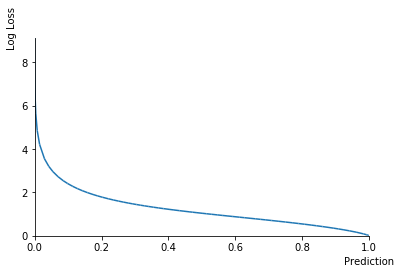

In [47]:
# Lets plot the log loss for the case that the image is a dog, i.e. y_i = 1
from sympy import symbols, log
from sympy import plot
import math

y = symbols('y')
loss = - ( 1*log(y) + (1-y)*log(1-y) )

plot(loss, (y, 0, 1), xlabel='Prediction', ylabel='Log Loss');

In [46]:
clipping = 0.05

isDog = isDog.clip(min=clipping, max=1-clipping)
display(isdog[:5])

array([ 0.95,  0.95,  0.95,  0.95,  0.05], dtype=float32)

### Create Submission

In [59]:
# Compile results into a Pandas Dataframe
subm = pd.DataFrame() 
subm.insert(0,"imageId",imageId) # insert id to the first column
subm.insert(1,"isDog",isDog) # insert predictions
display(subm.head(5))

,imageId,isDog
0,00001,0.95
1,00002,0.95
2,00003,0.95
3,00004,0.95
4,00005,0.05


In [78]:
from datetime import datetime


fname_submission_timestapped = '%s_%s.csv' % ( dir_submissions+fname_submission, datetime.now().strftime('%Y%m%d_%H%M%S'))

display(fname_submission_timestapped)

subm.to_csv(fname_submission_timestapped, index=False)

'./data/dogscats/submissions/Kaggle_CatsDogs_20171017_185424.csv'